In [1]:
# https://flinhong.com/2017/10/30/query-yahoo-finance-historical-data-via-python-requests/

import re
import sys
import time
import datetime
import requests
import pandas as pd


def get_cookie_value(r):
    return {'B': r.cookies['B']}

def get_page_data(symbol):
    url = "https://finance.yahoo.com/quote/%s/?p=%s" % (symbol, symbol)
    r = requests.get(url)
    cookie = get_cookie_value(r)
    lines = r.content.decode('unicode-escape').strip(). replace('}', '\n')
    return cookie, lines.split('\n')

def find_crumb_store(lines):
    for l in lines:
        if re.findall(r'CrumbStore', l):
            return l
    print("Did not find CrumbStore")

def split_crumb_store(v):
    return v.split(':')[2].strip('"')

def get_cookie_crumb(symbol):
    cookie, lines = get_page_data(symbol)
    crumb = split_crumb_store(find_crumb_store(lines))
    return cookie, crumb

def get_data(symbol, start_date, end_date, cookie, crumb):
    filename = '%s.csv' % (symbol)
    url = "https://query1.finance.yahoo.com/v7/finance/download/%s?period1=%s&period2=%s&interval=1d&events=history&crumb=%s" % (symbol, start_date, end_date, crumb)
    response = requests.get(url, cookies=cookie)
    return response

def get_now_epoch():
    return int(time.time())

def convert_to_dataframe(data, symbol):
    data = data.content.decode("utf-8").splitlines()
    data = [i.strip(',') for i in data]
    data = pd.DataFrame(data)
    data = data[0].str.split(',', expand=True)
    cols = data.iloc[0,:].values.tolist()
    data.columns = cols
    data = data[1:]
    data['symbol'] = symbol
    data['Date'] = pd.DatetimeIndex(data['Date'])
    data[['Open','High','Low','Close','Adj Close','Volume']] = data[['Open','High','Low','Close','Adj Close','Volume']].astype(float)
    return data

def download_quotes(symbols):

    if type(symbols)!=list:
        symbols = [symbols]
        
    start_date = 0
    end_date = get_now_epoch()
    
    stocks = []
    for symbol in symbols:
        cookie, crumb = get_cookie_crumb(symbol)
        data = get_data(symbol, start_date, end_date, cookie, crumb)
        stocks.append(convert_to_dataframe(data, symbol))
        
    return pd.concat(stocks, axis=0)


In [2]:
#if in eider, comment out following code
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
df = download_quotes(['^GSPC','AMZN'])
df.head()

/Users/dangoodb/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: invalid escape sequence '\/'


,Date,Open,High,Low,Close,Adj Close,Volume,symbol
1,1970-01-02,92.059998,93.540001,91.790001,93.000000,93.000000,8050000.0,^GSPC
2,1970-01-05,93.000000,94.250000,92.529999,93.459999,93.459999,11490000.0,^GSPC
3,1970-01-06,93.459999,93.809998,92.129997,92.820000,92.820000,11460000.0,^GSPC
4,1970-01-07,92.820000,93.379997,91.930000,92.629997,92.629997,10010000.0,^GSPC
5,1970-01-08,92.629997,93.470001,91.989998,92.680000,92.680000,10670000.0,^GSPC


# Your Turn!


1\. What was the "Open" price of Amazon stock (AMZN) on February 15, 2012?

In [4]:
# download AMZN quotes
az = download_quotes('AMZN')

az.loc[az.Date=='2012-02-15', 'Open']

/Users/dangoodb/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: invalid escape sequence '\/'


3714    191.289993
Name: Open, dtype: float64

2\. What was the highest volume of Amazon stock traded in one day?


In [5]:
az.Volume.max()

104329200.0

3\. On what day day did this occur?

In [6]:
# Method 1

az.loc[az.Volume.argmax(), ['Date','Volume']]

Date      2007-04-25 00:00:00
Volume            1.04329e+08
Name: 2501, dtype: object

In [7]:
# Method 2

az.loc[az.Volume==az.Volume.max(), ['Date','Volume']]

,Date,Volume
2501,2007-04-25,104329200.0


4\. What was Amazon's biggest one day stock growth in dollar terms? in percentage terms?

In [8]:
# Multiple ways to solve this


print('\nDifference between opening and closing price')

(az['Adj Close']-az['Open']).max()
az.loc[(az['Adj Close']-az['Open']).argmax(), ['Date','Open','Adj Close']]


print('\nChange in Adj Close')

az['Adj Close'].diff().max()
az.loc[[az['Adj Close'].diff().argmax(), az['Adj Close'].diff().argmax()-1], ['Date','Open','Adj Close']]


print('\nPercentage change in Adj Close')

az['Adj Close'].pct_change().max()
az.loc[az['Adj Close'].pct_change().argmax(), ['Date','Open','Adj Close']]


Difference between opening and closing price


81.38000499999998

Date         2018-02-06 00:00:00
Open                     1361.46
Adj Close                1442.84
Name: 5217, dtype: object


Change in Adj Close


128.5199580000001

,Date,Open,Adj Close
5149,2017-10-27,1058.140015,1100.949951
5148,2017-10-26,980.330017,972.429993



Percentage change in Adj Close


0.3447136563876654

Date         2001-11-26 00:00:00
Open                        9.83
Adj Close                  12.21
Name: 1140, dtype: object

5\. Create line chart showing Amazon stock price over time

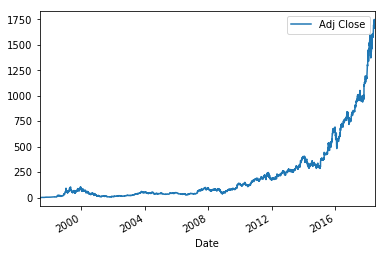

In [9]:
az.plot(y='Adj Close', x='Date')

6\. Create line chart showing average monthly stock price of Amazon (AMZN) vs S&P 500 (^GSPC) since January 2000 using Adj Close

hint: df['column'].dt.to_period("M") can convert a date to a month

/Users/dangoodb/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: invalid escape sequence '\/'
/Users/dangoodb/anaconda/lib/python3.6/site-packages/pandas/core/generic.py:2999: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


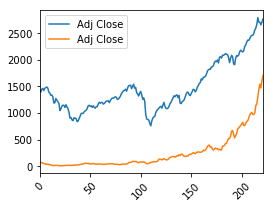

In [10]:
# Method 1

az = download_quotes('AMZN')
sp = download_quotes('^GSPC')

data = []

for df in [sp, az]:
    df = df[df['Date']>='2000-01-01']
    
    df.Date = df.Date.dt.to_period("M")
    df = df.groupby(['Date'])['Adj Close'].mean().reset_index()
    
    data.append(df)
    
df = pd.concat(data, axis=1)

df.plot(legend=True, figsize=(4,3), rot=45)

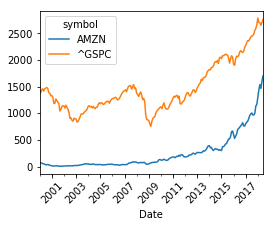

In [11]:
# Method 2

df = pd.concat([sp, az], axis=0)
df = df[df['Date']>='2000-01-01']

df.Date = df.Date.dt.to_period("M")
df = pd.pivot_table(df, index='Date', columns='symbol', values='Adj Close', aggfunc='mean')

df.plot(legend=True, figsize=(4,3), rot=45)

/Users/dangoodb/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: invalid escape sequence '\/'
/Users/dangoodb/anaconda/lib/python3.6/site-packages/pandas/core/groupby.py:1232: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  return get_resampler_for_grouping(self, rule, *args, **kwargs)


symbol
AMZN     Axes(0.125,0.125;0.775x0.755)
^GSPC    Axes(0.125,0.125;0.775x0.755)
Name: Adj Close, dtype: object

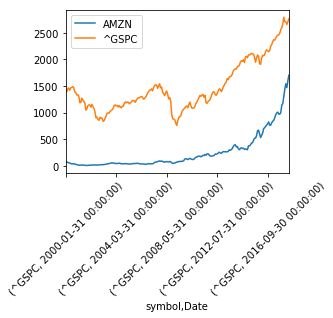

In [12]:
df = download_quotes(['AMZN','^GSPC'])
df = df[df['Date']>='2000-01-01']

(df
 .set_index(['Date'])
 .groupby('symbol')['Adj Close']
 .resample('M', how='mean')
 .groupby('symbol')
 .plot(legend=True, figsize=(4,3), rot=45)
)

7\. Create same chart in 6. but normalize it so that both stocks are set to 1.0 in January 2000

/Users/dangoodb/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: invalid escape sequence '\/'
/Users/dangoodb/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/dangoodb/anaconda/lib/python3.6/site-packages/pandas/core/generic.py:2999: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


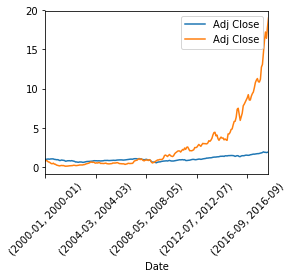

In [13]:
az = download_quotes('AMZN')
sp = download_quotes('^GSPC')

data = []

for df in [sp, az]:
    df = df[df['Date']>='2000-01-01']
    df['Adj Close'] /= df['Adj Close'].iloc[0]
    
    df.Date = df.Date.dt.to_period("M")
    df = df.groupby(['Date'])['Adj Close'].mean().reset_index()
    
    data.append(df)
    
df = pd.concat(data, axis=1)

df.plot(x='Date', legend=True, figsize=(4,3), rot=45)